In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

## Model setup

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練與評估模型（使用 5-fold + log 處理）
def train_and_evaluate_models_5fold(X, y_raw, target_name):
    print(f"\n===== Training models for: {target_name} =====")
    
    y_log = np.log1p(y_raw)  # 使用 log1p 轉換
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = {
        "SVR": SVR(),
        "RandomForest": RandomForestRegressor(random_state=42),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42)
    }
    
    results = []

    for model_name, model in models.items():
        mse_list = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y_log[train_idx], y_log[val_idx]
            
            model.fit(X_train, y_train)
            y_pred_log = model.predict(X_val)

            # 還原預測與實際值為原始空間
            y_pred = np.expm1(y_pred_log)
            y_val_real = np.expm1(y_val)

            mse = mean_squared_error(y_val_real, y_pred)
            mse_list.append(mse)

        avg_mse = np.mean(mse_list)
        results.append({
            "model": model_name,
            "target": target_name,
            "MSE": avg_mse
        })
        print(f"{model_name} - Avg MSE: {avg_mse:.4f}")

    return results

## Load data

In [3]:
# 載入資料
df = pd.read_csv("../../output_dataset/csr_text_processed_v0_preprocessed.csv")
all_results = []

for k in [1000, 2000, 3000, 5000]:
    for target in ["count", "citation"]:
        tfidf_path = f"../../output_dataset/tfidf_top{k}_{target}_k{k}.npz"
        X = sparse.load_npz(tfidf_path)
        y_raw = df["patent_count"].values if target == "count" else df["citation_count"].values

        results = train_and_evaluate_models_5fold(X, y_raw, target_name=f"{target}_k{k}")
        all_results.extend(results)

# 儲存結果
results_df = pd.DataFrame(all_results)
results_df.to_csv("../output/baseline_model_eval_results_5fold_log.csv", index=False)
print("✅ 所有模型訓練與評估完成，結果已儲存。")


===== Training models for: count_k1000 =====
SVR - Avg MSE: 641.0503
RandomForest - Avg MSE: 429.7328
DecisionTree - Avg MSE: 644.2583
XGBoost - Avg MSE: 433.7845

===== Training models for: citation_k1000 =====
SVR - Avg MSE: 43145.6896
RandomForest - Avg MSE: 36056.2620
DecisionTree - Avg MSE: 35023.8454
XGBoost - Avg MSE: 33445.2023

===== Training models for: count_k2000 =====
SVR - Avg MSE: 557.5795
RandomForest - Avg MSE: 453.7096
DecisionTree - Avg MSE: 721.2096
XGBoost - Avg MSE: 384.9207

===== Training models for: citation_k2000 =====
SVR - Avg MSE: 40923.9128
RandomForest - Avg MSE: 38302.0224
DecisionTree - Avg MSE: 36905.7325
XGBoost - Avg MSE: 35247.4046

===== Training models for: count_k3000 =====
SVR - Avg MSE: 565.2761
RandomForest - Avg MSE: 437.4971
DecisionTree - Avg MSE: 493.4466
XGBoost - Avg MSE: 364.3382

===== Training models for: citation_k3000 =====
SVR - Avg MSE: 43031.5724
RandomForest - Avg MSE: 38131.9606
DecisionTree - Avg MSE: 49700.5804
XGBoost - Avg

# Draw

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

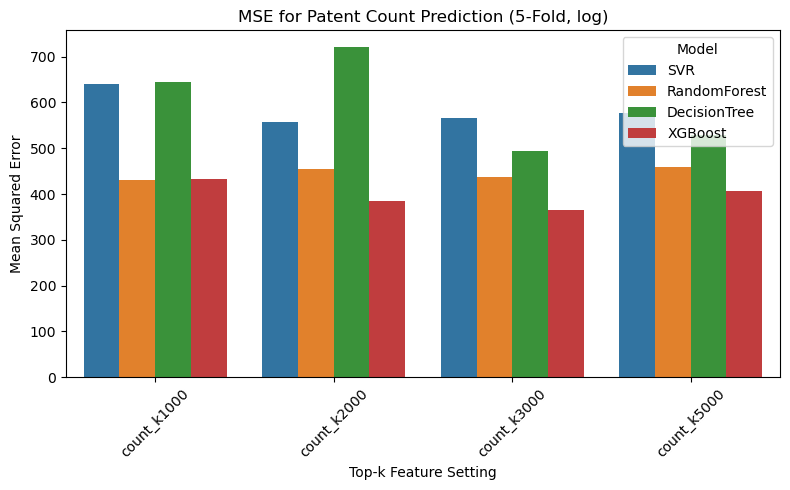

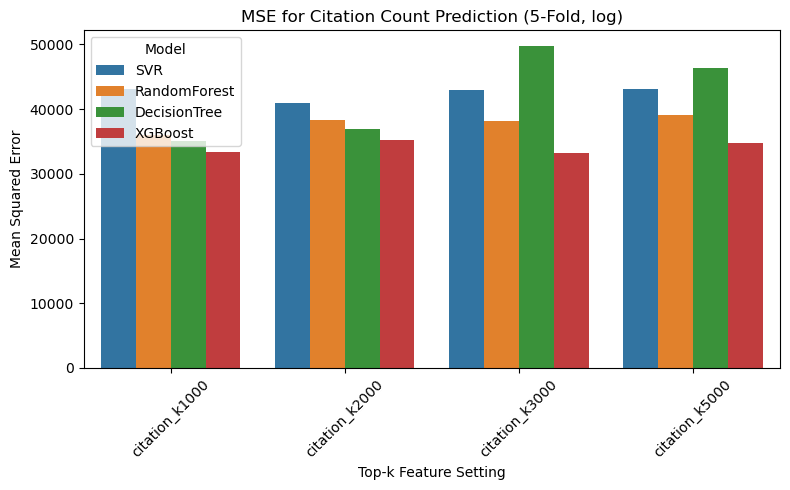

In [5]:
# 視覺化
# Barplot for count
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df[results_df["target"].str.contains("count")],
    x="target", y="MSE", hue="model"
)
plt.title("MSE for Patent Count Prediction (5-Fold, log)")
plt.ylabel("Mean Squared Error")
plt.xlabel("Top-k Feature Setting")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Barplot for citation
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df[results_df["target"].str.contains("citation")],
    x="target", y="MSE", hue="model"
)
plt.title("MSE for Citation Count Prediction (5-Fold, log)")
plt.ylabel("Mean Squared Error")
plt.xlabel("Top-k Feature Setting")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

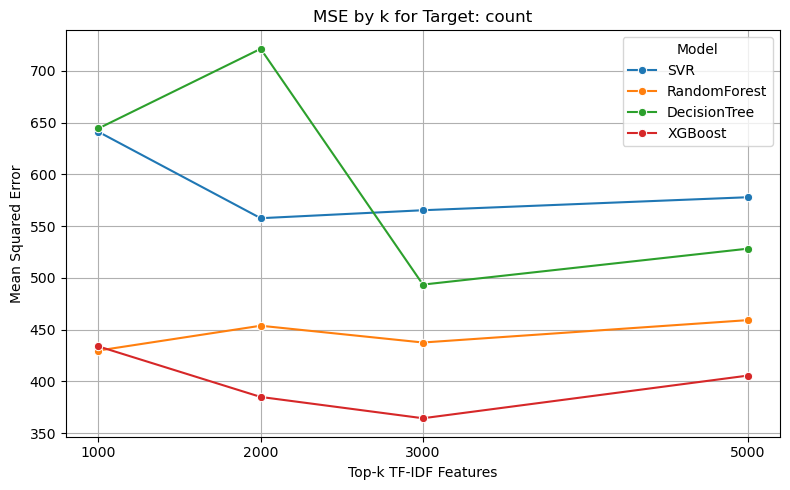

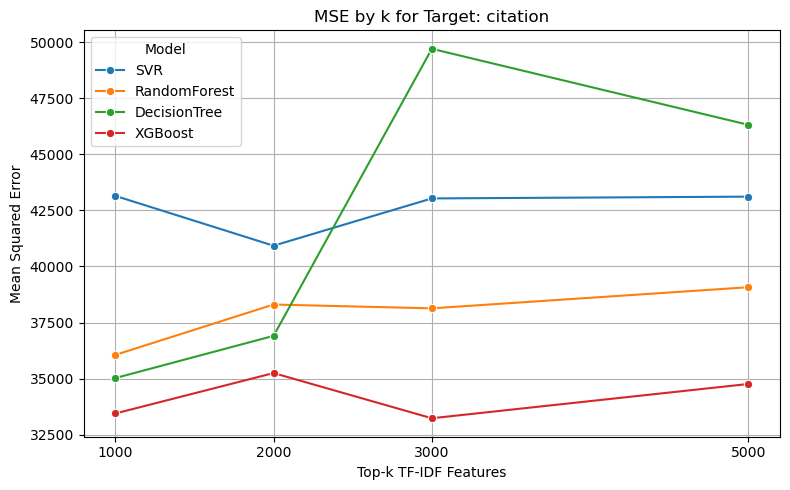

In [6]:
# 分解 target 為 type 與 k
results_df[['type', 'k']] = results_df['target'].str.extract(r'(\w+)_k(\d+)')
results_df['k'] = results_df['k'].astype(int)

# 繪圖：同一 target type 不同 k 值的變化趨勢
for target_type in results_df['type'].unique():
    plt.figure(figsize=(8, 5))
    subset = results_df[results_df['type'] == target_type]
    sns.lineplot(data=subset, x='k', y='MSE', hue='model', marker='o')
    plt.title(f"MSE by k for Target: {target_type}")
    plt.xlabel("Top-k TF-IDF Features")
    plt.ylabel("Mean Squared Error")
    plt.xticks(sorted(results_df['k'].unique()))
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


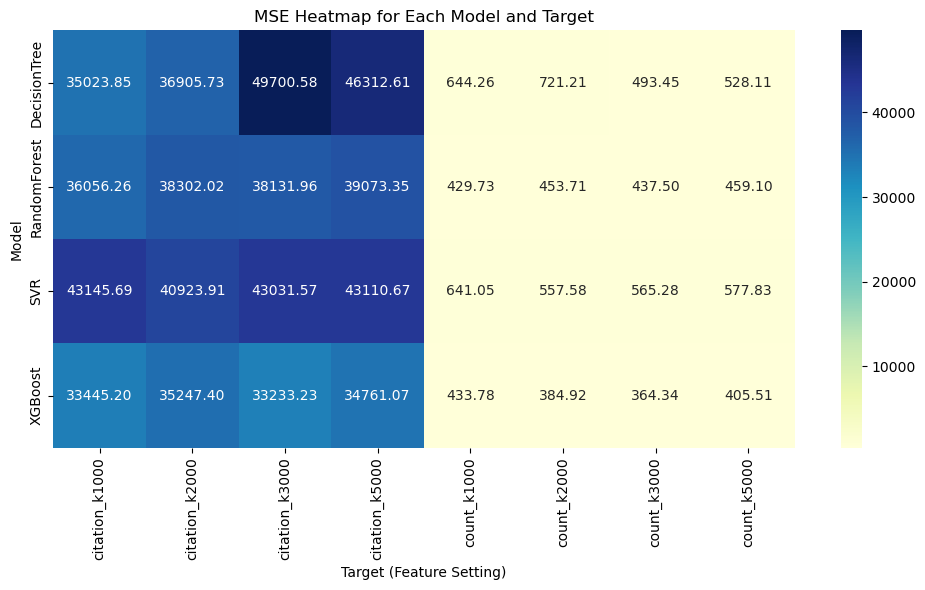

In [7]:
heatmap_data = results_df.pivot_table(index='model', columns='target', values='MSE')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("MSE Heatmap for Each Model and Target")
plt.xlabel("Target (Feature Setting)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
